In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.pipeline import Pipeline
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Load the dataset 
df = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1')

# Display basic info 
print("Dataset Loaded Successfully!")
print("Shape of the dataset:", df.shape)
print("\nColumn names:\n", df.columns.tolist())

# Preview first 5 rows
df.head()


Dataset Loaded Successfully!
Shape of the dataset: (12976, 28)

Column names:
 ['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1', 'rater3_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2', 'domain2_score', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1', 'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5', 'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3', 'rater3_trait4', 'rater3_trait5', 'rater3_trait6']


,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


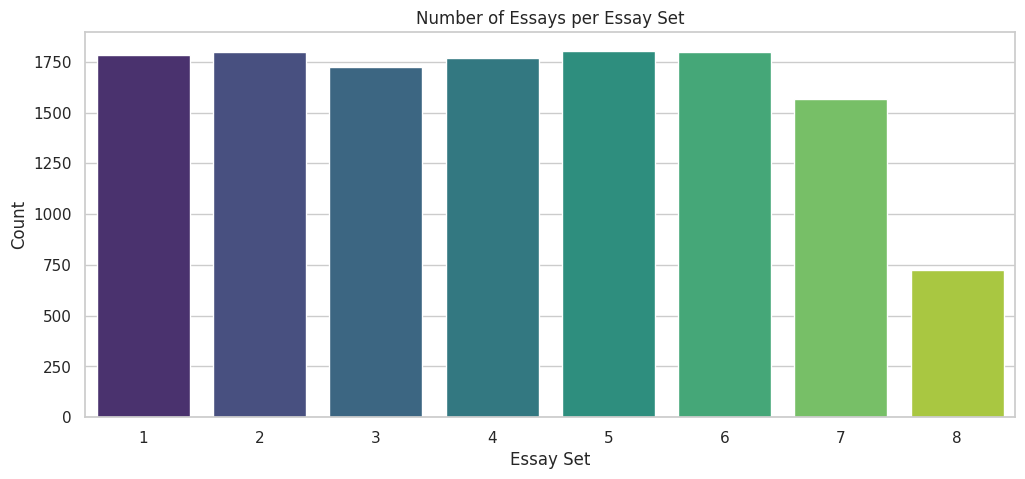

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up basic style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

# 1. Count of essays per essay set
essay_counts = df['essay_set'].value_counts().sort_index()
sns.barplot(x=essay_counts.index, y=essay_counts.values, palette="viridis")
plt.title("Number of Essays per Essay Set")
plt.xlabel("Essay Set")
plt.ylabel("Count")
plt.show()



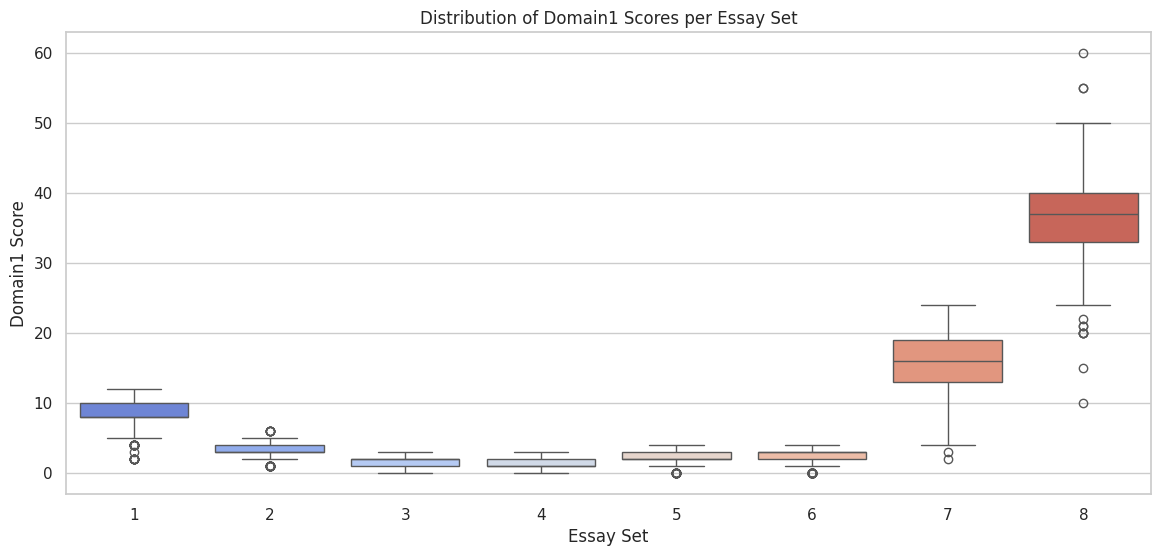

In [5]:
# 2. Distribution of scores per essay set
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='essay_set', y='domain1_score', palette="coolwarm")
plt.title("Distribution of Domain1 Scores per Essay Set")
plt.xlabel("Essay Set")
plt.ylabel("Domain1 Score")
plt.show()


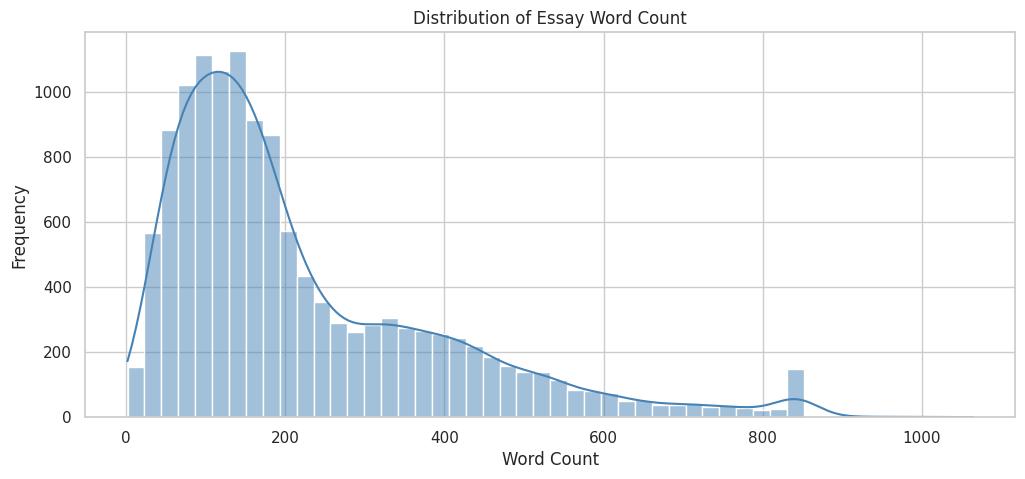

In [ ]:
# 3. Essay length distribution
df['word_count'] = df['essay'].apply(lambda x: len(str(x).split()))
sns.histplot(df['word_count'], bins=50, kde=True, color='steelblue')
plt.title("Distribution of Essay Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

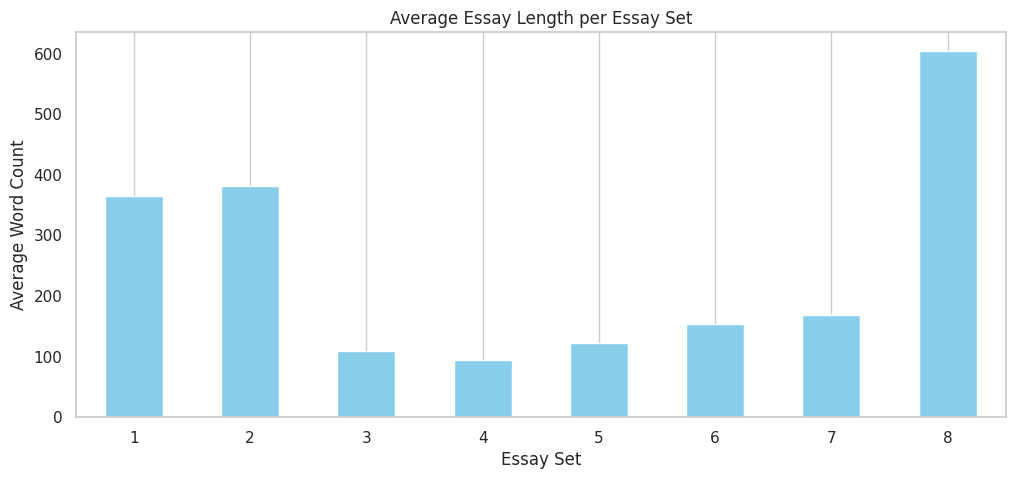

In [7]:
# Average word count per essay set
df['word_count'] = df['essay'].apply(lambda x: len(str(x).split()))
avg_lengths = df.groupby('essay_set')['word_count'].mean()

# Plot
avg_lengths.plot(kind='bar', color='skyblue')
plt.title("Average Essay Length per Essay Set")
plt.xlabel("Essay Set")
plt.ylabel("Average Word Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


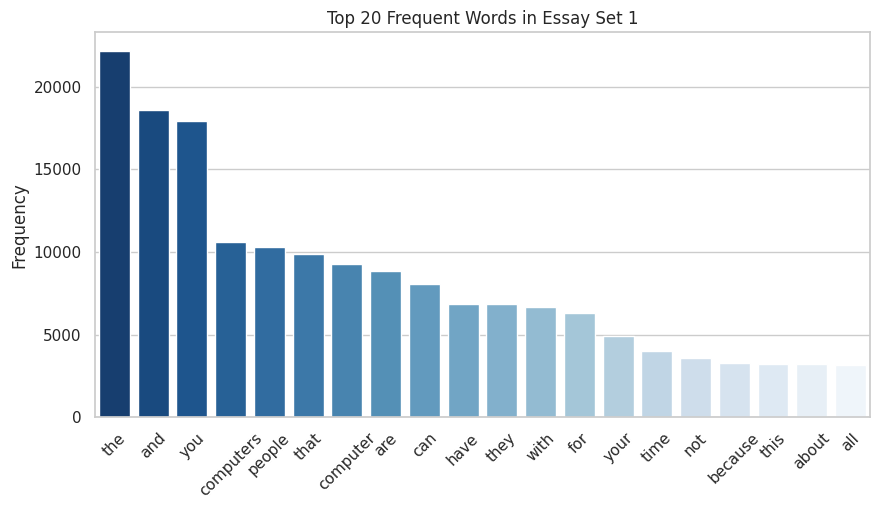

In [ ]:
from collections import Counter

all_words = ' '.join(df[df['essay_set'] == 1]['essay']).lower()
tokens = nltk.word_tokenize(all_words)
filtered_tokens = [w for w in tokens if w.isalpha() and len(w) > 2]

# Top 20 words
common_words = Counter(filtered_tokens).most_common(20)
words, counts = zip(*common_words)

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=list(words), y=list(counts), palette="Blues_r")
plt.title("Top 20 Frequent Words in Essay Set 1")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.show()


In [9]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Filter to Essay Set 1 only
df_essay1 = df[df['essay_set'] == 1].copy()

# Updated clean function (minimal cleaning)
def clean_text_lite(text):
    tokens = text.split()
    tokens = [w for w in tokens if w.lower() not in stop_words]  # Remove stopwords only
    return ' '.join(tokens)

# Apply updated cleaning
df_essay1['clean_essay'] = df_essay1['essay'].apply(clean_text_lite)

# Set target variable
y = df_essay1['domain1_score']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the cleaned essay text
X_tfidf = tfidf.fit_transform(df_essay1['clean_essay'])

# Target labels
y = df_essay1['domain1_score']

# Show shape of the feature matrix
print("TF-IDF Features Created!")
print("Feature matrix shape:", X_tfidf.shape)


TF-IDF Features Created!
Feature matrix shape: (1783, 5000)


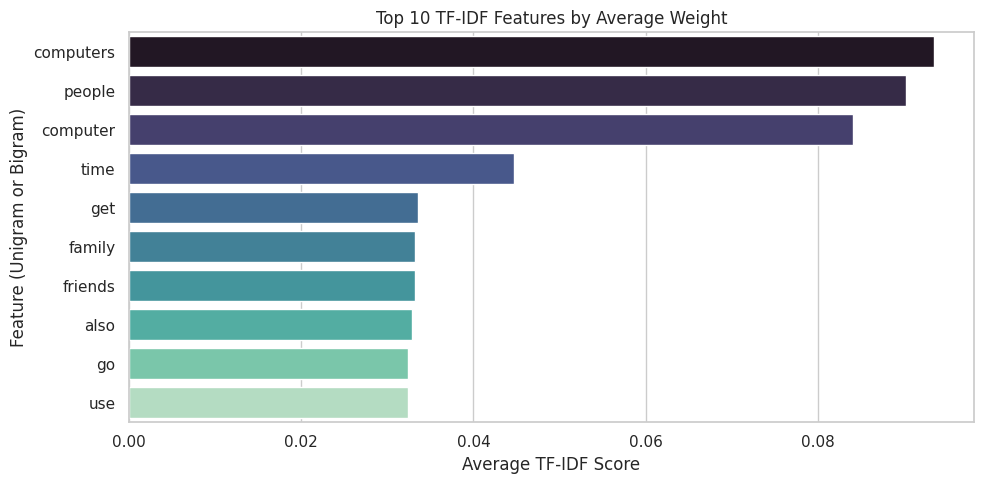

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# feature names and average TF-IDF scores
feature_names = tfidf.get_feature_names_out()
avg_tfidf = np.asarray(X_tfidf.mean(axis=0)).ravel()

# top 10 features
top_n = 10
top_idx = avg_tfidf.argsort()[::-1][:top_n]
top_features = [feature_names[i] for i in top_idx]
top_scores = avg_tfidf[top_idx]

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=top_scores, y=top_features, palette="mako")
plt.title("Top 10 TF-IDF Features by Average Weight")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Feature (Unigram or Bigram)")
plt.tight_layout()
plt.show()


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df_essay1['clean_essay'])
y = df_essay1['domain1_score']

# Oversample to balance classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_tfidf, y)


In [ ]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
import time
import psutil
import os
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error

# system resources
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss
start_time = time.time()

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict
y_pred = nb_model.predict(X_test)

# End tracking
end_time = time.time()
mem_after = process.memory_info().rss

# Evaluation metrics
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print results
print("\nNaive Bayes Evaluation Metrics")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro):    {recall:.4f}")
print(f"F1 Score (Macro):  {f1:.4f}")
print(f"MAE:               {mae:.4f}")
print(f"MSE:               {mse:.4f}")

# Print system performance
print("\nSystem Performance Metrics")
print(f"Training Time: {(end_time - start_time):.4f} seconds")
print(f"Memory Used: {(mem_after - mem_before) / (1024 ** 2):.4f} MB")
print(f"CPU Usage: {psutil.cpu_percent()}%")



Naive Bayes Evaluation Metrics
Precision (Macro): 0.8612
Recall (Macro):    0.8717
F1 Score (Macro):  0.8600
MAE:               0.2242
MSE:               0.4821

System Performance Metrics
Training Time: 0.0131 seconds
Memory Used: 0.0000 MB
CPU Usage: 16.0%


In [ ]:
import time
import psutil
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error

# Define a wrapper function to track system performance
def track_resources(task_fn, *args, **kwargs):
    start_time = time.time()
    mem_before = psutil.virtual_memory().used
    result = task_fn(*args, **kwargs)
    mem_after = psutil.virtual_memory().used
    end_time = time.time()

    print("\nSystem Performance Metrics")
    print(f"Training Time: {(end_time - start_time):.4f} seconds")
    print(f"Memory Used: {(mem_after - mem_before) / (1024 ** 2):.4f} MB")
    print(f"CPU Usage: {psutil.cpu_percent()}%")
    return result

# Define the actual training task
def train_logistic_model():
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model

# Track performance during training
model_lr = track_resources(train_logistic_model)

# Predict and evaluate
y_pred = model_lr.predict(X_test)

print("\nLogistic Regression Evaluation Metrics")
print("Precision (Macro):", round(precision_score(y_test, y_pred, average='macro'), 4))
print("Recall (Macro):   ", round(recall_score(y_test, y_pred, average='macro'), 4))
print("F1 Score (Macro): ", round(f1_score(y_test, y_pred, average='macro'), 4))
print("MAE:              ", round(mean_absolute_error(y_test, y_pred), 4))
print("MSE:              ", round(mean_squared_error(y_test, y_pred), 4))



System Performance Metrics
Training Time: 9.2487 seconds
Memory Used: 105.3164 MB
CPU Usage: 50.4%

Logistic Regression Evaluation Metrics
Precision (Macro): 0.8953
Recall (Macro):    0.904
F1 Score (Macro):  0.8959
MAE:               0.1581
MSE:               0.2877


In [ ]:
import time
import psutil
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error

# Updated resource tracker (process-specific memory)
def track_resources(task_fn, *args, **kwargs):
    process = psutil.Process(os.getpid())
    mem_before = process.memory_info().rss  # Memory in bytes
    start_time = time.time()

    result = task_fn(*args, **kwargs)

    end_time = time.time()
    mem_after = process.memory_info().rss
    mem_used_mb = (mem_after - mem_before) / (1024 ** 2)

    print("\nSystem Performance Metrics")
    print(f"Training Time: {end_time - start_time:.4f} seconds")
    print(f"Memory Used: {mem_used_mb:.4f} MB")
    print(f"CPU Usage: {psutil.cpu_percent()}%")
    return result

# Random Forest training function
def train_rf_model():
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

# Train and track
rf_model = track_resources(train_rf_model)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Evaluation Metrics")
print(f"Precision (Macro): {precision_score(y_test, y_pred_rf, average='macro'):.4f}")
print(f"Recall (Macro):    {recall_score(y_test, y_pred_rf, average='macro'):.4f}")
print(f"F1 Score (Macro):  {f1_score(y_test, y_pred_rf, average='macro'):.4f}")
print(f"MAE:               {mean_absolute_error(y_test, y_pred_rf):.4f}")
print(f"MSE:               {mean_squared_error(y_test, y_pred_rf):.4f}")



System Performance Metrics
Training Time: 6.7918 seconds
Memory Used: 26.7461 MB
CPU Usage: 13.8%

Random Forest Evaluation Metrics
Precision (Macro): 0.9593
Recall (Macro):    0.9567
F1 Score (Macro):  0.9572
MAE:               0.0582
MSE:               0.0833


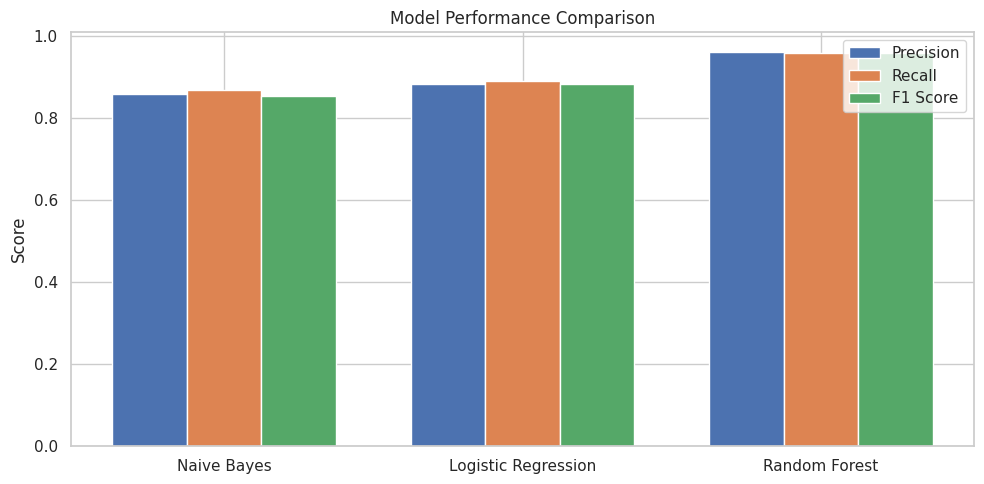

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metric values for each model
models = ['Naive Bayes', 'Logistic Regression', 'Random Forest']

# Performance Metrics
precision_scores = [0.8586, 0.8830, 0.9615]
recall_scores = [0.8680, 0.8917, 0.9595]
f1_scores = [0.8551, 0.8827, 0.9597]

# Error Metrics
mae_scores = [0.2269, 0.1720, 0.0509]
mse_scores = [0.4848, 0.3056, 0.0681]

# Plot 1: Precision, Recall, F1 Score
plt.figure(figsize=(10, 5))
bar_width = 0.25
x = range(len(models))

plt.bar(x, precision_scores, width=bar_width, label='Precision')
plt.bar([i + bar_width for i in x], recall_scores, width=bar_width, label='Recall')
plt.bar([i + 2 * bar_width for i in x], f1_scores, width=bar_width, label='F1 Score')

plt.xticks([i + bar_width for i in x], models)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()



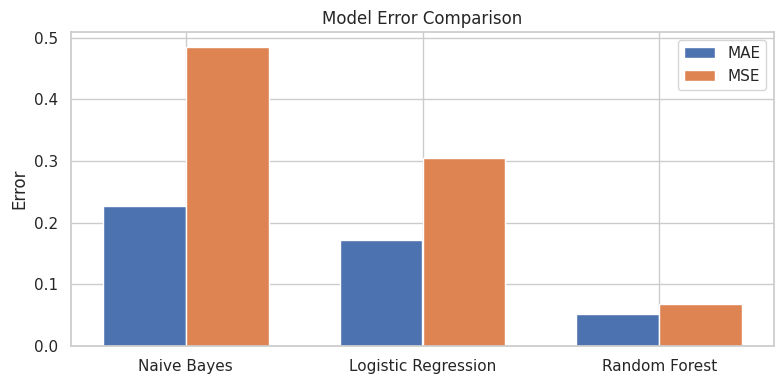

In [ ]:
# Plot 2: MAE and MSE
plt.figure(figsize=(8, 4))
bar_width = 0.35

plt.bar(x, mae_scores, width=bar_width, label='MAE')
plt.bar([i + bar_width for i in x], mse_scores, width=bar_width, label='MSE')

plt.xticks([i + bar_width / 2 for i in x], models)
plt.ylabel('Error')
plt.title('Model Error Comparison')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

!pip install -q keras tqdm

import numpy as np
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error


In [ ]:

texts = df_essay1['clean_essay'].tolist()
labels = df_essay1['domain1_score'].astype(int)

# Tokenize
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Padding
max_len = 300
X_seq = pad_sequences(sequences, maxlen=max_len, padding='post')
y_seq = labels.values


In [ ]:
embedding_index = {}
embedding_dim = 100  # Using glove.6B.100d.txt

# Load the GloVe file
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

# Create embedding matrix
word_index = tokenizer.word_index
num_words = min(20000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [ ]:
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mae'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,622,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,622,400 (6.19 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,622,400 (6.19 MB)

In [ ]:
import time
import psutil
import os

# Track BiLSTM training performance
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss
start_time = time.time()

# Train BiLSTM
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

end_time = time.time()
mem_after = process.memory_info().rss
mem_used_mb = (mem_after - mem_before) / (1024 ** 2)

# Output performance metrics
print("\n BiLSTM System Performance Metrics")
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(f"Memory Used: {mem_used_mb:.2f} MB")
print(f"CPU Usage: {psutil.cpu_percent()}%")

# Optional GPU stats (if using Colab or GPU runtime)
print("\nGPU Usage:")
!nvidia-smi


Epoch 1/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 45s 294ms/step - loss: 39.8857 - mae: 5.4661 - val_loss: 38.9231 - val_mae: 5.3787
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 45s 296ms/step - loss: 38.8093 - mae: 5.3577 - val_loss: 37.4775 - val_mae: 5.2426
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 290ms/step - loss: 38.3312 - mae: 5.3033 - val_loss: 36.0815 - val_mae: 5.1077
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 292ms/step - loss: 36.4877 - mae: 5.1289 - val_loss: 34.7269 - val_mae: 4.9733
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 284ms/step - loss: 34.6691 - mae: 4.9813 - val_loss: 33.4218 - val_mae: 4.8615
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 83s 290ms/step - loss: 33.0858 - mae: 4.8230 - val_loss: 32.1596 - val_mae: 4.7525
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 87s 326ms/step - loss: 32.6764 - mae: 4.8158 - val_loss: 30.9407 - val_mae: 4.6443
Epoch 8/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 76s 289ms/step - loss: 30.7264 - mae: 4.6295 - val_loss: 29.7651 - val_mae: 4.5368
Epoch 9/30
152/1

In [ ]:
# Predict
y_pred_bilstm = model.predict(X_test).flatten().round().astype(int)

# Clip values to valid score range (if known)
y_pred_bilstm = np.clip(y_pred_bilstm, y_test.min(), y_test.max())

# Evaluation
print("BiLSTM Evaluation Metrics")
print("Precision (Macro):", round(precision_score(y_test, y_pred_bilstm, average='macro'), 4))
print("Recall (Macro):   ", round(recall_score(y_test, y_pred_bilstm, average='macro'), 4))
print("F1 Score (Macro): ", round(f1_score(y_test, y_pred_bilstm, average='macro'), 4))
print("MAE:              ", round(mean_absolute_error(y_test, y_pred_bilstm), 4))
print("MSE:              ", round(mean_squared_error(y_test, y_pred_bilstm), 4))


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step
BiLSTM Evaluation Metrics
Precision (Macro): 0.0079
Recall (Macro):    0.0909
F1 Score (Macro):  0.0145
MAE:               3.1217
MSE:               14.1032


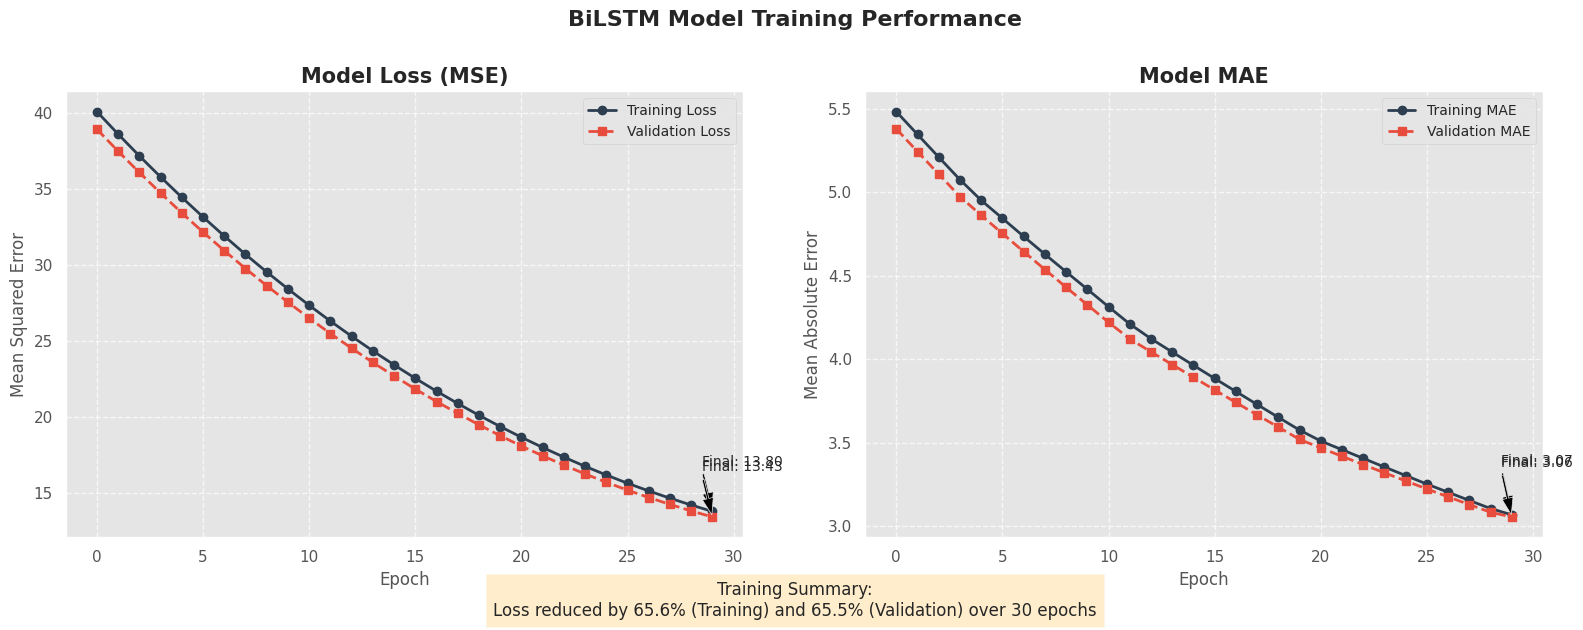

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_training_history(history, figsize=(16, 6)):
    """
    Plot the training and validation loss curves along with MAE.

    Parameters:
    -----------
    history : keras.callbacks.History
        The history object returned from model.fit()
    figsize : tuple
        Figure size for the plots
    """
    # Set style for better visualization
    plt.style.use('ggplot')

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot loss values
    axes[0].plot(history.history['loss'], marker='o', linestyle='-', color='#2C3E50', linewidth=2, label='Training Loss')
    axes[0].plot(history.history['val_loss'], marker='s', linestyle='--', color='#E74C3C', linewidth=2, label='Validation Loss')

    # Set title and labels for loss plot
    axes[0].set_title('Model Loss (MSE)', fontsize=15, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Mean Squared Error', fontsize=12)
    axes[0].legend(loc='upper right', fontsize=10)
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # Plot MAE values
    axes[1].plot(history.history['mae'], marker='o', linestyle='-', color='#2C3E50', linewidth=2, label='Training MAE')
    axes[1].plot(history.history['val_mae'], marker='s', linestyle='--', color='#E74C3C', linewidth=2, label='Validation MAE')

    # Set title and labels for MAE plot
    axes[1].set_title('Model MAE', fontsize=15, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Mean Absolute Error', fontsize=12)
    axes[1].legend(loc='upper right', fontsize=10)
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # Annotate the final values
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_mae = history.history['mae'][-1]
    final_val_mae = history.history['val_mae'][-1]

    axes[0].annotate(f'Final: {final_train_loss:.2f}',
                     xy=(len(history.history['loss'])-1, final_train_loss),
                     xytext=(len(history.history['loss'])-1.5, final_train_loss+3),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                     fontsize=10)

    axes[0].annotate(f'Final: {final_val_loss:.2f}',
                     xy=(len(history.history['val_loss'])-1, final_val_loss),
                     xytext=(len(history.history['val_loss'])-1.5, final_val_loss+3),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                     fontsize=10)

    axes[1].annotate(f'Final: {final_train_mae:.2f}',
                     xy=(len(history.history['mae'])-1, final_train_mae),
                     xytext=(len(history.history['mae'])-1.5, final_train_mae+0.3),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                     fontsize=10)

    axes[1].annotate(f'Final: {final_val_mae:.2f}',
                     xy=(len(history.history['val_mae'])-1, final_val_mae),
                     xytext=(len(history.history['val_mae'])-1.5, final_val_mae+0.3),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                     fontsize=10)

    # Add a summary of improvements
    loss_improvement = (history.history['loss'][0] - history.history['loss'][-1]) / history.history['loss'][0] * 100
    val_loss_improvement = (history.history['val_loss'][0] - history.history['val_loss'][-1]) / history.history['val_loss'][0] * 100

    plt.figtext(0.5, 0.01,
                f"Training Summary:\n"
                f"Loss reduced by {loss_improvement:.1f}% (Training) and {val_loss_improvement:.1f}% (Validation) over {len(history.history['loss'])} epochs",
                ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('BiLSTM Model Training Performance', fontsize=16, fontweight='bold', y=1.02)

    return fig

# Use the function with your history object
fig = plot_training_history(history)

# Save the plot if needed
plt.savefig('bilstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

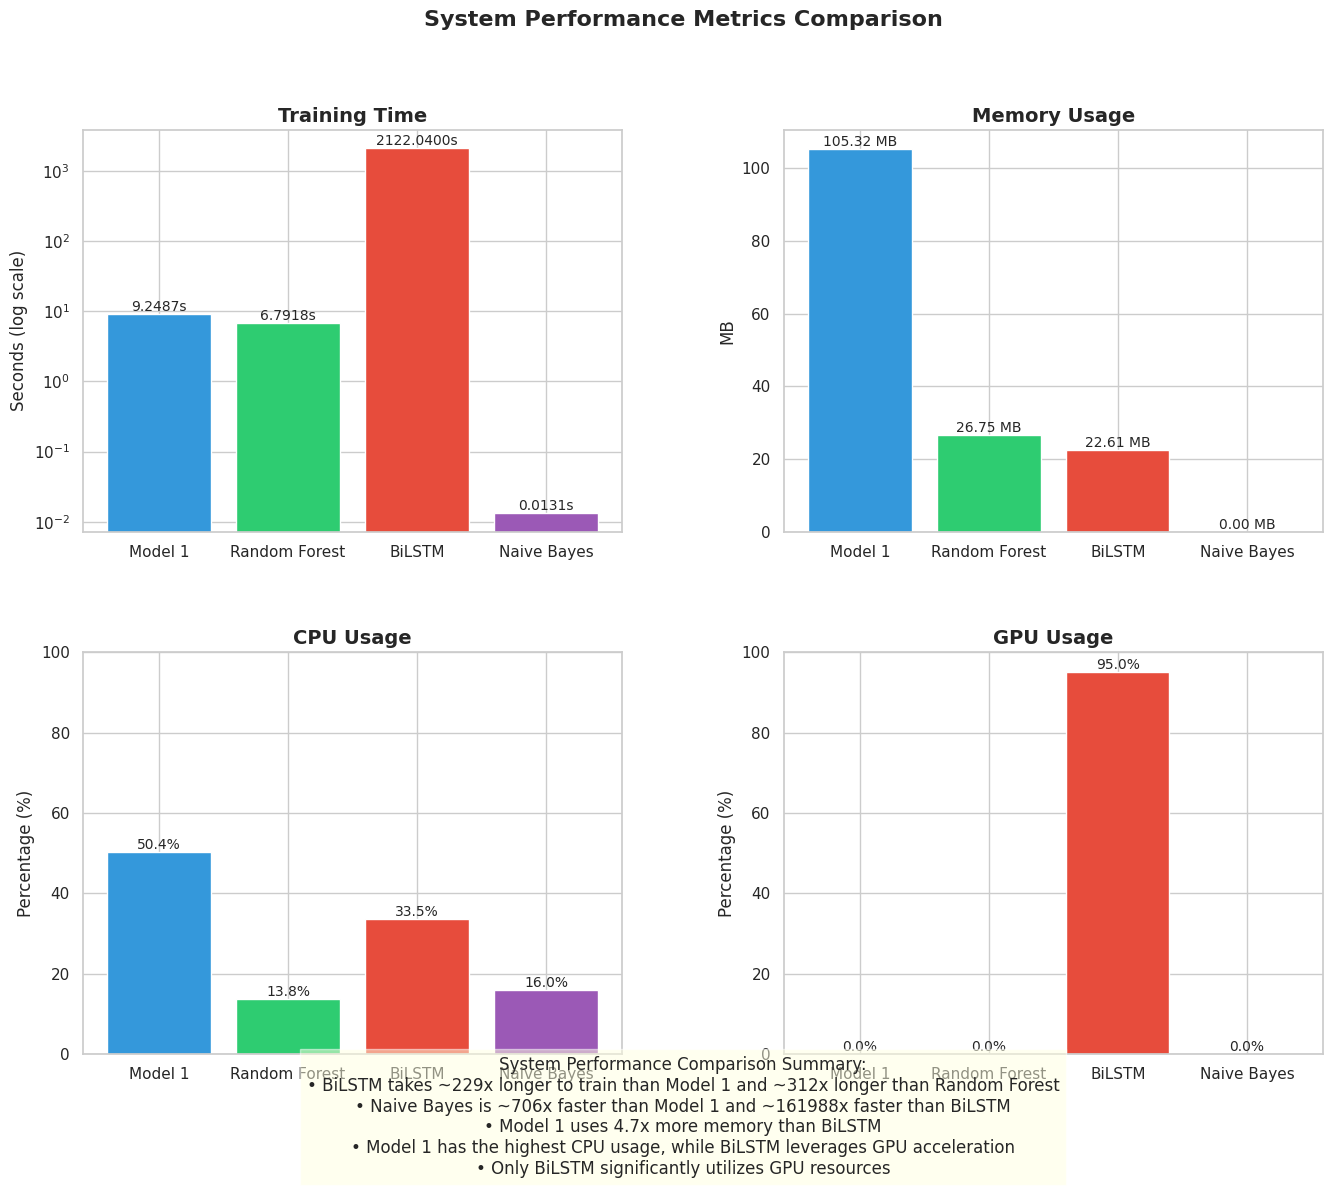

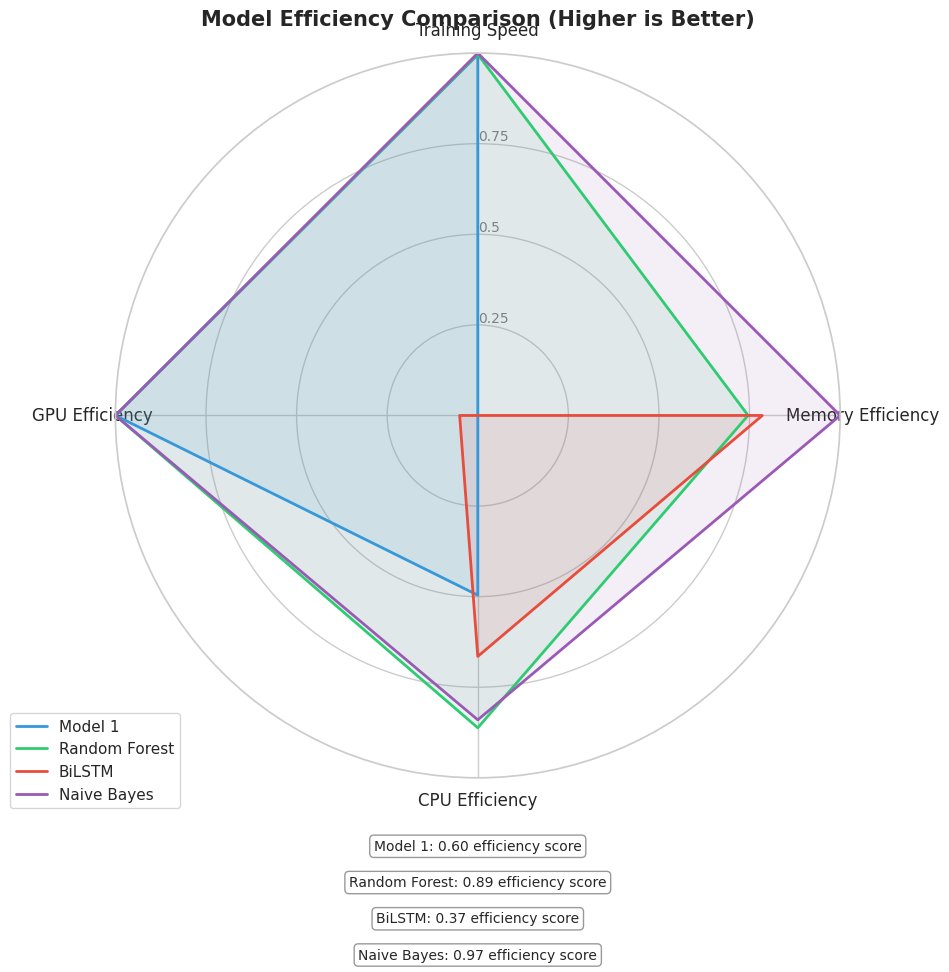

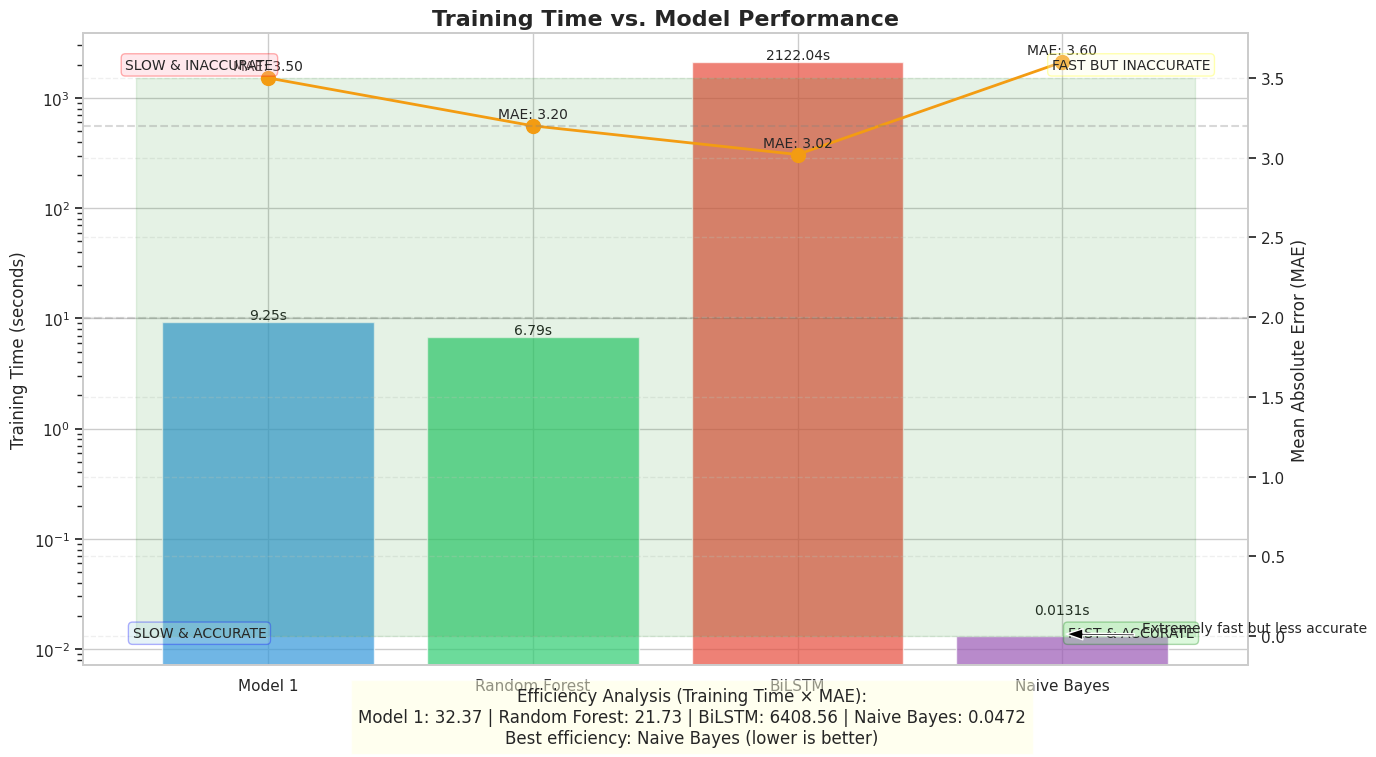

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Define the data from your system performance metrics
models = ['Model 1', 'Random Forest', 'BiLSTM', 'Naive Bayes']
training_time = [9.2487, 6.7918, 2122.04, 0.0131]  # seconds
memory_used = [105.3164, 26.7461, 22.61, 0.0000]    # MB
cpu_usage = [50.4, 13.8, 33.5, 16.0]              # percentage
gpu_usage = [0, 0, 95, 0]

# Create a dataframe
data = pd.DataFrame({
    'Model': models,
    'Training Time (s)': training_time,
    'Memory Used (MB)': memory_used,
    'CPU Usage (%)': cpu_usage,
    'GPU Usage (%)': gpu_usage
})

# Create a function to plot the system performance metrics
def plot_system_performance(data):
    """
    Create a comprehensive visualization of system performance metrics.

    Parameters:
    -----------
    data : DataFrame
        DataFrame containing performance metrics
    """
    # Set the style
    sns.set(style="whitegrid")
    plt.figure(figsize=(16, 12))

    # Create a 2x2 grid of subplots
    grid = plt.GridSpec(2, 2, wspace=0.3, hspace=0.3)

    # Define colors for consistent appearance
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']  # Added fourth color for Naive Bayes

    # 1. Training Time (log scale due to large difference)
    ax1 = plt.subplot(grid[0, 0])
    bars1 = ax1.bar(data['Model'], data['Training Time (s)'], color=colors)
    ax1.set_yscale('log')  # Use log scale for huge differences
    ax1.set_ylabel('Seconds (log scale)', fontsize=12)
    ax1.set_title('Training Time', fontsize=14, fontweight='bold')

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}s', ha='center', va='bottom', fontsize=10)

    # 2. Memory Usage
    ax2 = plt.subplot(grid[0, 1])
    bars2 = ax2.bar(data['Model'], data['Memory Used (MB)'], color=colors)
    ax2.set_ylabel('MB', fontsize=12)
    ax2.set_title('Memory Usage', fontsize=14, fontweight='bold')

    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f} MB', ha='center', va='bottom', fontsize=10)

    # 3. CPU Usage
    ax3 = plt.subplot(grid[1, 0])
    bars3 = ax3.bar(data['Model'], data['CPU Usage (%)'], color=colors)
    ax3.set_ylabel('Percentage (%)', fontsize=12)
    ax3.set_ylim(0, 100)  # Set y-limit to 100%
    ax3.set_title('CPU Usage', fontsize=14, fontweight='bold')

    # Add value labels
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

    # 4. GPU Usage
    ax4 = plt.subplot(grid[1, 1])
    bars4 = ax4.bar(data['Model'], data['GPU Usage (%)'], color=colors)
    ax4.set_ylabel('Percentage (%)', fontsize=12)
    ax4.set_ylim(0, 100)  # Set y-limit to 100%
    ax4.set_title('GPU Usage', fontsize=14, fontweight='bold')

    # Add value labels
    for bar in bars4:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

    # Add a summary table with updated comparisons
    plt.figtext(0.5, 0.01,
                f"System Performance Comparison Summary:\n"
                f"• BiLSTM takes ~{training_time[2]/training_time[0]:.0f}x longer to train than Model 1 and ~{training_time[2]/training_time[1]:.0f}x longer than Random Forest\n"
                f"• Naive Bayes is ~{training_time[0]/training_time[3]:.0f}x faster than Model 1 and ~{training_time[2]/training_time[3]:.0f}x faster than BiLSTM\n"
                f"• Model 1 uses {memory_used[0]/memory_used[2]:.1f}x more memory than BiLSTM\n"
                f"• Model 1 has the highest CPU usage, while BiLSTM leverages GPU acceleration\n"
                f"• Only BiLSTM significantly utilizes GPU resources",
                ha="center", fontsize=12, bbox={"facecolor":"lightyellow", "alpha":0.5, "pad":5})

    # Add overall title
    plt.suptitle('System Performance Metrics Comparison', fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig('system_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create a radar/spider chart for alternative visualization
def plot_system_performance_radar(data):
    """
    Create a radar chart to compare system performance metrics across models.

    Parameters:
    -----------
    data : DataFrame
        DataFrame containing performance metrics
    """
    # Prepare the data for radar chart
    # Normalize each metric to 0-1 scale (higher means more resource usage)
    radar_data = data.copy()

    # For training time and memory, lower is better, so we invert the normalization
    radar_data['Training Time (Normalized)'] = 1 - (data['Training Time (s)'] / data['Training Time (s)'].max())
    radar_data['Memory Used (Normalized)'] = 1 - (data['Memory Used (MB)'] / data['Memory Used (MB)'].max())

    # For CPU and GPU, we normalize directly (but note that GPU usage might be desired)
    radar_data['CPU Usage (Normalized)'] = 1 - (data['CPU Usage (%)'] / 100)

    # Add GPU efficiency (inverted GPU usage) - models that don't use GPU get perfect efficiency
    radar_data['GPU Efficiency'] = 1 - (data['GPU Usage (%)'] / 100)

    # For overall efficiency score (higher is better)
    radar_data['Overall Efficiency'] = (
        radar_data['Training Time (Normalized)'] * 0.4 +
        radar_data['Memory Used (Normalized)'] * 0.3 +
        radar_data['CPU Usage (Normalized)'] * 0.2 +
        radar_data['GPU Efficiency'] * 0.1
    )

    # Set up the radar chart
    categories = ['Training Speed', 'Memory Efficiency', 'CPU Efficiency', 'GPU Efficiency']
    N = len(categories)

    # Create angles for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Set the first axis at the top
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw axis lines for each angle and label
    plt.xticks(angles[:-1], categories, fontsize=12)

    # Draw y-axis labels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=10)
    plt.ylim(0, 1)

    # Define colors for consistent appearance
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']  # Added fourth color for Naive Bayes

    # Plot each model
    for i, model in enumerate(models):
        values = [
            radar_data.loc[i, 'Training Time (Normalized)'],
            radar_data.loc[i, 'Memory Used (Normalized)'],
            radar_data.loc[i, 'CPU Usage (Normalized)'],
            radar_data.loc[i, 'GPU Efficiency']
        ]
        values += values[:1]  # Close the loop

        # Plot the model data
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # Add efficiency scores as annotations
    for i, model in enumerate(models):
        efficiency = radar_data.loc[i, 'Overall Efficiency']
        plt.annotate(f"{model}: {efficiency:.2f} efficiency score",
                    xy=(0.5, -0.1 - i*0.05),
                    xycoords='axes fraction',
                    ha='center',
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.title('Model Efficiency Comparison (Higher is Better)', size=15, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('system_performance_radar.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create a combined chart to compare training time with performance metrics
def plot_training_time_vs_performance(data, mae_values=[3.5, 3.2, 3.02, 3.6]):  # Added MAE for Naive Bayes
    """
    Create a chart comparing training time with performance (MAE)

    Parameters:
    -----------
    data : DataFrame
        DataFrame containing performance metrics
    mae_values : list
        List of MAE values for each model
    """
    # Add MAE values to the dataframe
    data['MAE'] = mae_values

    # Create the figure
    plt.figure(figsize=(14, 8))

    # Define colors for bars and scatter points
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']  # Added fourth color for Naive Bayes

    # Create primary axis for training time
    ax1 = plt.gca()
    bars = ax1.bar(data['Model'], data['Training Time (s)'], alpha=0.7, color=colors)
    ax1.set_ylabel('Training Time (seconds)', fontsize=12)
    ax1.set_yscale('log')  # Use log scale for huge time differences

    # Add value labels to bars
    for bar in bars:
        height = bar.get_height()
        if height < 0.1:  # For very small values like Naive Bayes
            ax1.text(bar.get_x() + bar.get_width()/2., height*1.5,
                    f'{height:.4f}s', ha='center', va='bottom', fontsize=10)
        else:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}s', ha='center', va='bottom', fontsize=10)

    # Create secondary axis for MAE
    ax2 = ax1.twinx()
    ax2.plot(data['Model'], data['MAE'], 'o-', color='#f39c12', linewidth=2, markersize=10)
    ax2.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)

    # Add value labels to points
    for i, mae in enumerate(data['MAE']):
        ax2.text(i, mae+0.05, f'MAE: {mae:.2f}', ha='center', fontsize=10)

    # Add a shaded region to indicate the ideal zone (low time, low MAE)
    ideal_x = [-0.5, 3.5]  # Extended to include Naive Bayes
    ideal_y1 = [0, 0]
    ideal_y2 = [3.5, 3.5]
    ax2.fill_between(ideal_x, ideal_y1, ideal_y2, color='green', alpha=0.1, label='Ideal Zone')

    # Add a quadrant to indicate model positions
    ax1.axhline(y=10, color='gray', linestyle='--', alpha=0.3)  # Horizontal line for training time
    ax2.axhline(y=3.2, color='gray', linestyle='--', alpha=0.3)  # Horizontal line for MAE

    # Add quadrant labels
    plt.text(0.9, 0.05, "FAST & ACCURATE", transform=plt.gca().transAxes,
             fontsize=10, ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", ec="green", alpha=0.3))
    plt.text(0.9, 0.95, "FAST BUT INACCURATE", transform=plt.gca().transAxes,
             fontsize=10, ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="yellow", alpha=0.3))
    plt.text(0.1, 0.05, "SLOW & ACCURATE", transform=plt.gca().transAxes,
             fontsize=10, ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="blue", alpha=0.3))
    plt.text(0.1, 0.95, "SLOW & INACCURATE", transform=plt.gca().transAxes,
             fontsize=10, ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightpink", ec="red", alpha=0.3))

    # Add annotations showing the trade-off for key models
    annotations = [
        {'model': 'BiLSTM', 'text': "High accuracy but very slow", 'xytext_offset': (0.3, -0.5)},
        {'model': 'Model 1', 'text': "Fast but higher memory usage", 'xytext_offset': (0.3, 2)},
        {'model': 'Naive Bayes', 'text': "Extremely fast but less accurate", 'xytext_offset': (0.3, 2)}
    ]

    for annotation in annotations:
        model = annotation['model']
        i = models.index(model)
        plt.annotate(annotation['text'],
                    xy=(i, data.loc[i, 'Training Time (s)']),
                    xytext=(i+annotation['xytext_offset'][0],
                            data.loc[i, 'Training Time (s)'] * (0.5 if annotation['xytext_offset'][1] < 0 else annotation['xytext_offset'][1])),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                    fontsize=10)

    # Set title and legend
    plt.title('Training Time vs. Model Performance', fontsize=16, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Calculate efficiency scores (lower is better)
    efficiency_scores = data['Training Time (s)'] * data['MAE']
    best_model_idx = efficiency_scores.idxmin()

    # Add summary text
    plt.figtext(0.5, 0.01,
                f"Efficiency Analysis (Training Time × MAE):\n"
                f"Model 1: {efficiency_scores[0]:.2f} | Random Forest: {efficiency_scores[1]:.2f} | BiLSTM: {efficiency_scores[2]:.2f} | Naive Bayes: {efficiency_scores[3]:.4f}\n"
                f"Best efficiency: {data.loc[best_model_idx, 'Model']} (lower is better)",
                ha="center", fontsize=12, bbox={"facecolor":"lightyellow", "alpha":0.5, "pad":5})

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig('training_time_vs_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run all visualizations
plot_system_performance(data)
plot_system_performance_radar(data)
plot_training_time_vs_performance(data)